In [83]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as st
import statsmodels as sm
import matplotlib
import pandas as pd
import io
import requests
import seaborn as sns
from sklearn.metrics import classification_report

%matplotlib inline

In [114]:
df = pd.read_csv("mulit_classification_data.csv")
df.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [119]:
df_target=df.iloc[:,27:]

In [85]:
# 'type' 컬럼 생성 및 값 설정
df['type'] = 'TypeOfSteel_A300'
df.loc[df['TypeOfSteel_A400'] == 1, 'type'] = 'TypeOfSteel_A400'
# 'TypeOfSteel_A300'와 'TypeOfSteel_A400' 컬럼 삭제
df.drop(['TypeOfSteel_A300', 'TypeOfSteel_A400'], axis=1, inplace=True)

In [86]:
df['Total_Perimeter'] = df['X_Perimeter'] + df['Y_Perimeter']
df.drop(['X_Perimeter', 'Y_Perimeter'], axis=1, inplace=True)

In [87]:
df['Mean_of_Luminosity'] = (df['Minimum_of_Luminosity'] + df['Maximum_of_Luminosity']) / 2
df.drop(['Minimum_of_Luminosity', 'Maximum_of_Luminosity'], axis=1, inplace=True)

In [88]:
df['type'].replace({"TypeOfSteel_A300":0,"TypeOfSteel_A400":1},inplace=True) # TypeOfSteel_A300 -> 0 , TypeOfSteel_A400 -> 1

In [89]:
# target 데이터 -> int bool 타입으로 변경 
target_df=[
              df['Pastry'],
            df['Z_Scratch'],
            df['K_Scatch'],
            df['Stains'],
            df['Dirtiness'],
            df['Bumps'],
            df['Other_Faults'] 
]
targets = list(map(lambda i: i.astype(bool),target_df))
choices = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
df.drop( df[choices].columns, axis=1, inplace=True)
df['class']=np.select(targets,choices)

In [91]:
# 데이터를 표준화
df_1 = df.iloc[:,:-1]
from sklearn.preprocessing import StandardScaler
# StandardScaler 객체 생성
standard_scaler = StandardScaler()
np_scaled = standard_scaler.fit_transform(df_1)
df_norm = pd.DataFrame(np_scaled, columns=list(df_1.columns))
df_norm.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,Sum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Edges_Index,Empty_Index,...,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,type,Total_Perimeter,Mean_of_Luminosity
0,-1.016481,-1.141639,-0.777729,-0.777729,-0.314852,-0.355537,1.576303,0.022920,-0.940864,-1.258531,...,0.879804,-0.083538,-0.898437,0.528872,1.467656,-1.075752,-0.009490,-1.223956,-0.187982,-0.705828
1,0.141894,0.066403,0.500188,0.500171,-0.345623,-0.380574,1.576303,0.022920,1.445043,-0.254349,...,0.879804,-0.581936,-1.157841,0.130174,1.417530,-0.297824,-0.845759,-1.223956,-0.217481,-0.177761
2,0.495362,0.436253,-0.054546,-0.054566,-0.352784,-0.387261,1.133521,0.386082,2.133548,-0.521791,...,0.879804,-0.812814,-1.157841,-0.325764,1.165103,0.057185,-1.091513,-1.223956,-0.235743,0.212549
3,0.541467,0.486504,-0.722225,-0.722225,-0.332463,-0.365736,-0.734467,3.836121,1.324897,0.197460,...,0.879804,-0.313021,-1.018897,0.550227,1.519978,-0.171419,-0.189237,0.817023,-0.192196,0.235509
4,1.379032,1.382988,-0.649678,-0.649559,0.099692,0.079307,-0.734467,1.929520,-0.875117,0.250657,...,0.879804,1.127655,-0.218461,2.216130,1.698514,-0.456503,1.221636,0.817023,0.175842,-1.187976


<Axes: >

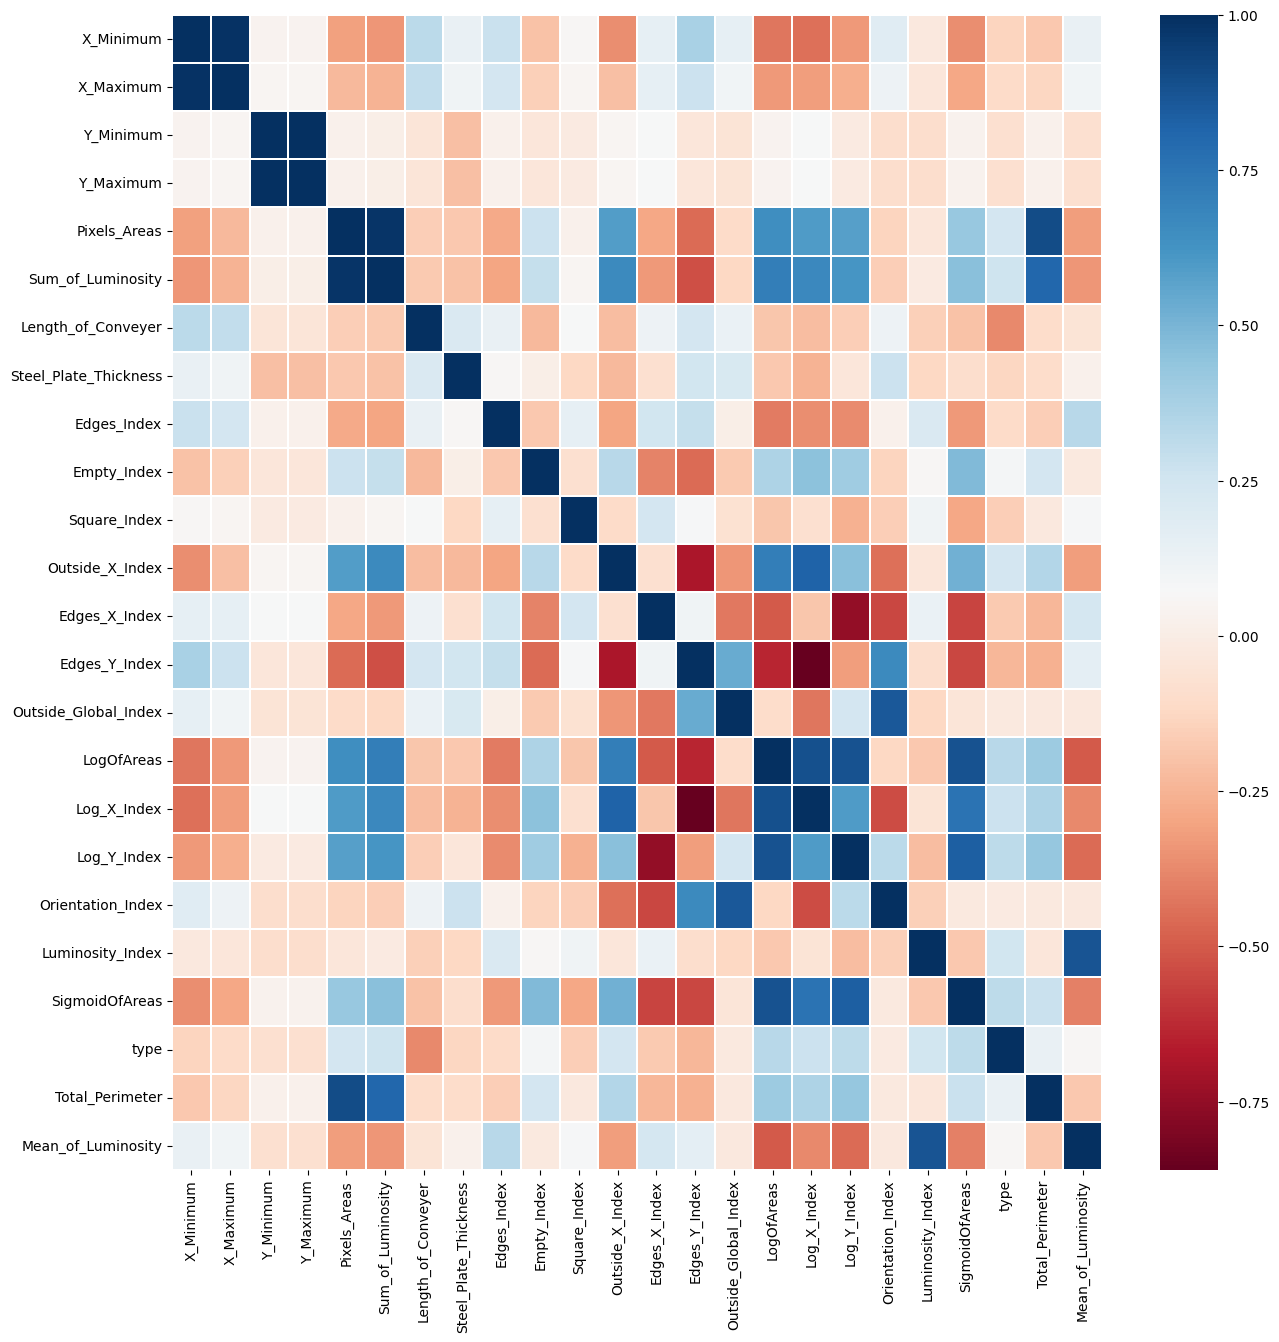

In [93]:
# 변수간 상관관계 파악
plt.subplots(figsize=(15, 15))
corr = np.round_(df_norm.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdBu',linewidths=0.1)

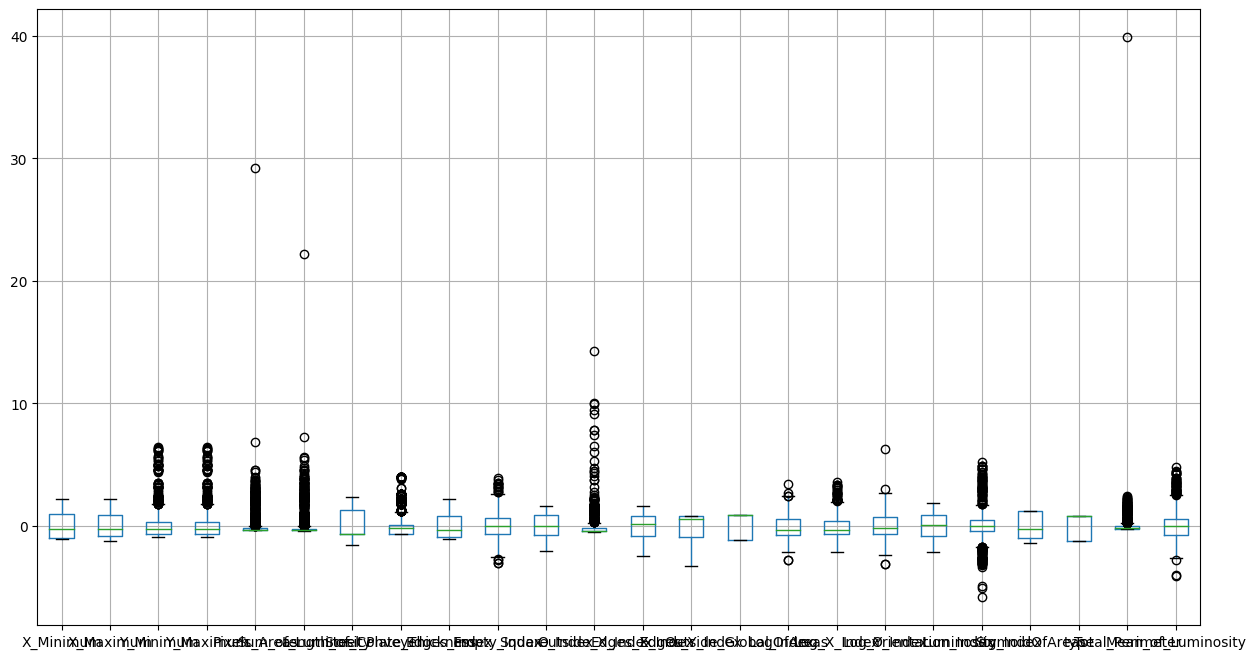

In [94]:
# 이상치 파악
boxplot = df_norm.boxplot(figsize=(15,8))

In [95]:
low = .05
high = .95
quantiles = df_norm.quantile([low, high])
quantiles

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,Sum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Edges_Index,Empty_Index,...,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,type,Total_Perimeter,Mean_of_Luminosity
0.05,-1.070270,-1.183850,-0.881514,-0.881514,-0.358977,-0.394339,-0.734467,-0.703404,-1.067685,-1.500468,...,-1.193905,-1.142713,-1.157841,-1.550479,-1.506948,-1.456311,-1.225292,-1.223956,-0.248385,-1.325732
0.95,1.857366,1.895552,1.624600,1.624574,1.803153,2.122857,1.610896,2.201892,1.906272,1.680414,...,0.879804,1.974336,1.884397,1.820954,1.505599,1.135660,1.221636,0.817023,1.124031,1.268683


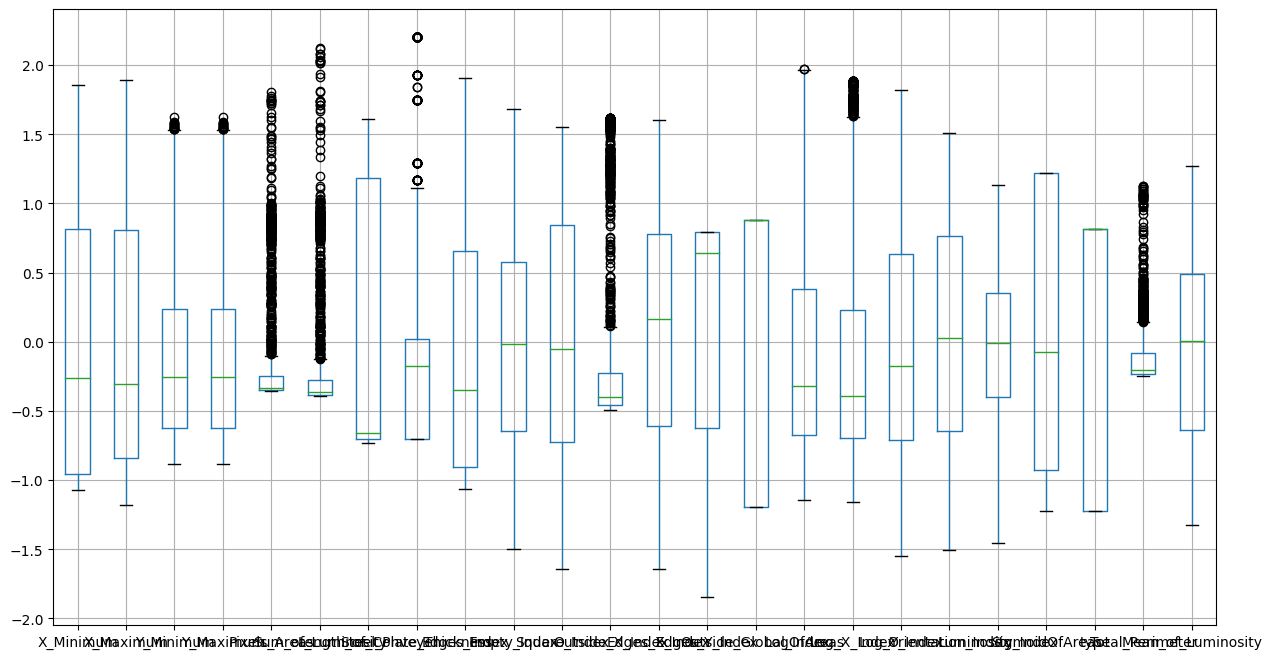

In [96]:
quantile_norm = df_norm.apply(lambda col: col[(col >= quantiles.loc[low,col.name]) & 
                                    (col <= quantiles.loc[high,col.name])], axis=0)
boxplot = quantile_norm.boxplot(figsize=(15,8))

In [97]:
# 상관계수 행렬 생성
corr_matrix = df_norm.corr().abs()

# 상삼각 행렬 부분(대각선 기준으로 위쪽)만 남기기 위해 적용
under = corr_matrix * (np.triu(np.ones(corr_matrix.shape), k=1))

# 상관계수가 0.95보다 큰 변수들 찾기
to_drop = [column for column in under.columns if any(under[column] > 0.95)]

print(to_drop)


['X_Maximum', 'Y_Maximum', 'Sum_of_Luminosity']


In [98]:
df_norm = df_norm.drop(df_norm[to_drop], axis=1)
df_norm.head()

,X_Minimum,Y_Minimum,Pixels_Areas,Length_of_Conveyer,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,...,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,type,Total_Perimeter,Mean_of_Luminosity
0,-1.016481,-0.777729,-0.314852,1.576303,0.022920,-0.940864,-1.258531,-1.435364,-0.486227,-0.575331,...,0.879804,-0.083538,-0.898437,0.528872,1.467656,-1.075752,-0.009490,-1.223956,-0.187982,-0.705828
1,0.141894,0.500188,-0.345623,1.576303,0.022920,1.445043,-0.254349,-1.342740,-0.504888,-0.043290,...,0.879804,-0.581936,-1.157841,0.130174,1.417530,-0.297824,-0.845759,-1.223956,-0.217481,-0.177761
2,0.495362,-0.054546,-0.352784,1.133521,0.386082,2.133548,-0.521791,-0.876299,-0.503191,0.573451,...,0.879804,-0.812814,-1.157841,-0.325764,1.165103,0.057185,-1.091513,-1.223956,-0.235743,0.212549
3,0.541467,-0.722225,-0.332463,-0.734467,3.836121,1.324897,0.197460,-1.532047,-0.477744,-0.296153,...,0.879804,-0.313021,-1.018897,0.550227,1.519978,-0.171419,-0.189237,0.817023,-0.192196,0.235509
4,1.379032,-0.649678,0.099692,-0.734467,1.929520,-0.875117,0.250657,-1.861950,-0.352206,-1.345434,...,0.879804,1.127655,-0.218461,2.216130,1.698514,-0.456503,1.221636,0.817023,0.175842,-1.187976


In [113]:
df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,Sum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Edges_Index,Empty_Index,...,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,type,Total_Perimeter,Mean_of_Luminosity,class
0,42,50,270900,270944,267,24220,1687,80,0.0498,0.2415,...,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,0,61,92.0,Pastry
1,645,651,2538079,2538108,108,11397,1687,80,0.7647,0.3793,...,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,0,40,103.5,Pastry
2,829,835,1553913,1553931,71,7972,1623,100,0.9710,0.3426,...,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,0,27,112.0,Pastry
3,853,860,369370,369415,176,18996,1353,290,0.7287,0.4413,...,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,58,112.5,Pastry
4,1289,1306,498078,498335,2409,246930,1353,185,0.0695,0.4486,...,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,320,81.5,Pastry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,35033,1360,40,0.3662,0.3906,...,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254,1,76,130.0,Other_Faults
1937,144,175,340581,340598,287,34599,1360,40,0.2118,0.4554,...,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173,1,68,122.5,Other_Faults
1938,145,174,386779,386794,292,37572,1360,40,0.2132,0.3287,...,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079,1,62,130.0,Other_Faults
1939,137,170,422497,422528,419,52715,1360,40,0.2015,0.5904,...,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919,1,144,128.5,Other_Faults


In [121]:
from sklearn.preprocessing import LabelEncoder
X= df_norm
le=LabelEncoder()
targets=df_target.idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: count, dtype: int64


In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [127]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
print(f'RandomForestClassifier 예측 정확도(accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       132
           1       0.82      0.69      0.75        13
           2       0.96      0.93      0.94       123
           3       0.70      0.78      0.74       197
           4       0.59      0.59      0.59        39
           5       0.86      0.82      0.84        22
           6       0.89      0.88      0.88        57

    accuracy                           0.78       583
   macro avg       0.79      0.76      0.78       583
weighted avg       0.78      0.78      0.78       583

RandomForestClassifier 예측 정확도(accuracy) 77.9%


In [126]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
print(f'LogisticRegression 예측 정확도 (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.65      0.58      0.62       132
           1       0.58      0.54      0.56        13
           2       0.95      0.91      0.93       123
           3       0.65      0.70      0.67       197
           4       0.60      0.54      0.57        39
           5       0.87      0.91      0.89        22
           6       0.77      0.88      0.82        57

    accuracy                           0.73       583
   macro avg       0.72      0.72      0.72       583
weighted avg       0.73      0.73      0.73       583

LogisticRegression 예측 정확도 (accuracy) 72.9%


In [128]:
# SVC
from sklearn.svm import SVC
model = SVC()

model.fit(X_train, y_train)
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

print(f'SVC 예측정확도 (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       132
           1       0.75      0.69      0.72        13
           2       0.98      0.90      0.94       123
           3       0.67      0.70      0.68       197
           4       0.55      0.41      0.47        39
           5       0.87      0.91      0.89        22
           6       0.76      0.84      0.80        57

    accuracy                           0.74       583
   macro avg       0.75      0.73      0.74       583
weighted avg       0.74      0.74      0.74       583

SVC 예측정확도 (accuracy) 73.9%


In [131]:
# 클래스 불균형 -> 조절 
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print('수행 전 데이터 수:', len(X_train))
print('수행 후 데이터 수:', len(X_resampled))


수행 전 데이터 수: 1358
수행 후 데이터 수: 3332


In [132]:
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))   # 클래스 비율 조절 

{0: 476, 1: 476, 2: 476, 3: 476, 4: 476, 5: 476, 6: 476}

In [133]:
model=RandomForestClassifier(n_estimators=100)
model.fit(X_resampled, y_resampled)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
print(f'RandomForestClassifier: class 조절 정확도 (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.71      0.72      0.72       132
           1       0.82      0.69      0.75        13
           2       0.97      0.92      0.94       123
           3       0.74      0.72      0.73       197
           4       0.54      0.69      0.61        39
           5       0.91      0.91      0.91        22
           6       0.84      0.86      0.85        57

    accuracy                           0.78       583
   macro avg       0.79      0.79      0.79       583
weighted avg       0.79      0.78      0.78       583

RandomForestClassifier: class 조절 정확도 (accuracy) 78.0%


In [134]:
model = LogisticRegression()
model.fit(X_resampled, y_resampled)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
print(f'LogisticRegression: class 조절 정확도 (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.61      0.62      0.62       132
           1       0.21      0.62      0.31        13
           2       0.93      0.92      0.92       123
           3       0.77      0.40      0.53       197
           4       0.39      0.72      0.50        39
           5       0.75      0.95      0.84        22
           6       0.60      0.91      0.73        57

    accuracy                           0.66       583
   macro avg       0.61      0.73      0.64       583
weighted avg       0.71      0.66      0.66       583

LogisticRegression: class 조절 정확도 (accuracy) 65.7%


In [135]:
model = SVC()
model.fit(X_resampled, y_resampled)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
print(f'SVC: class 조절 정확도 (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.64      0.73      0.68       132
           1       0.53      0.77      0.62        13
           2       0.93      0.90      0.92       123
           3       0.82      0.54      0.65       197
           4       0.47      0.74      0.57        39
           5       0.81      0.95      0.88        22
           6       0.68      0.91      0.78        57

    accuracy                           0.73       583
   macro avg       0.70      0.79      0.73       583
weighted avg       0.76      0.73      0.73       583

SVC: class 조절 정확도 (accuracy) 73.1%


In [139]:
# RandomForestClassifier: class 조절한 정확도가 가장 높게 나옴